 - ReLU 계층
 
 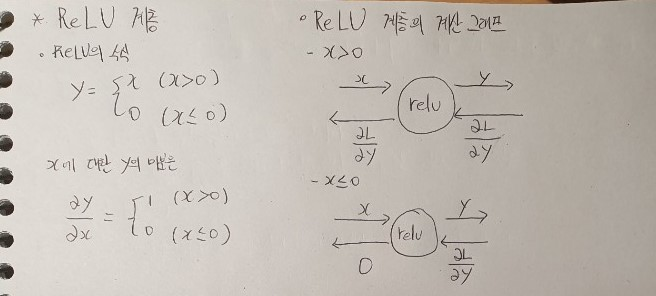

In [1]:
# ReLU 구현

class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [2]:
import numpy as np

x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

mask = (x<=0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


- Sigmoid 계층

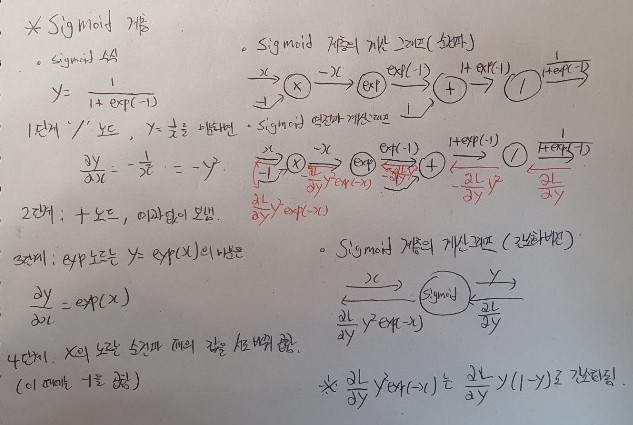

In [3]:
# sigmoid 계층
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1/ (1+np.exp(-x))
        self.out = out
        return out
    
    def backward(self,x):
        dx = dout * (1.0- self.out)* self.out
        return dx
    

# Affine/Softmax 계층 구현하기

- Affine 계층 : 신경망의 순전파 계산 때 수행하는 행렬의 곱은 기하학에서 어파인(Affine) 변환이라고 한다. 여기서는 어파인 변환을 수행하는 처리를 Affine 계층으로 구현한다.

아래 그림처럼 행렬의 곱을 구현할 때 Affine 계층의 계산 그래프는 아래와 같다.
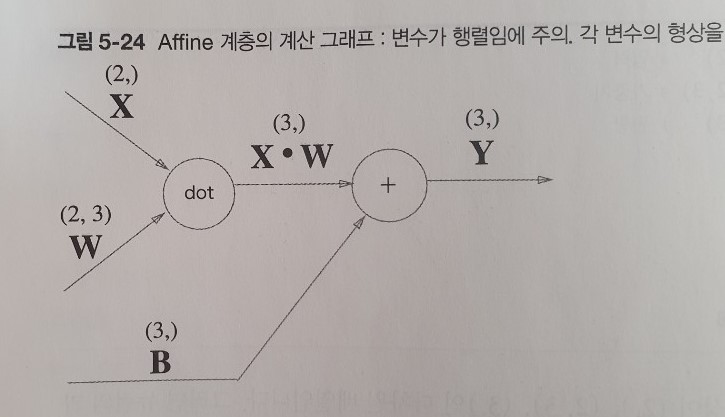


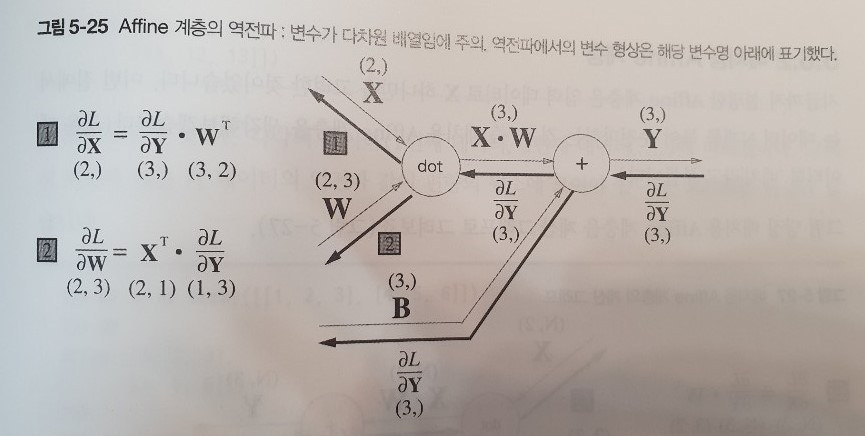

- 배치용 Affine 계층

위에서 설명한 Affine 계층은 입력 데이터 X 하나만을 고려한 것이였다. 여기서는 데이터 N개를 묶어 순전파 하는 경우, 즉 배치용 계층을 설명한다.

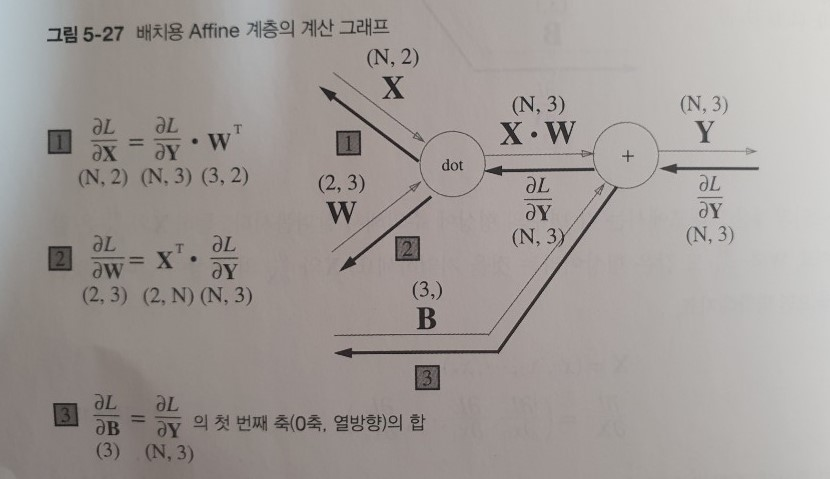

In [6]:
# 위의 구체적인 예
X_dot_W = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])

print(X_dot_W)

X_dot_W + B

[[ 0  0  0]
 [10 10 10]]


array([[ 1,  2,  3],
       [11, 12, 13]])

In [8]:
# 각 데이터의 역전파 값의 편향의 원소
dY = np.array([[1,2,3],[4,5,6]])
print(dY)

dB = np.sum(dY, axis=0)
dB

[[1 2 3]
 [4 5 6]]


array([5, 7, 9])

In [10]:
# Affine 구현
import numpy as np

class Affine:
    def __init__(self):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        slef.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, x):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx


# SoftMax-with-Loss 계층

출력층에서 사용하는 소프트맥스에 대해 알아보자. 소프트 맥스는 입력 값을 정규화하여 출력한다. 예를 들어 손글씨 숫자 인식에서의 SoftMax 계층의 출력은 아래와 같다

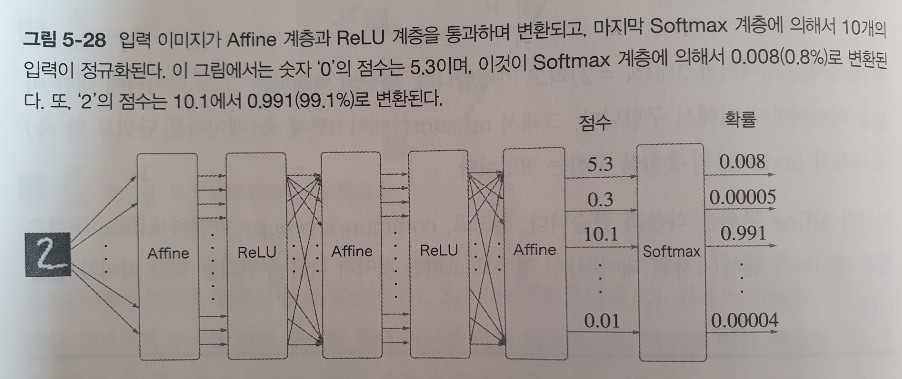

※ 신경망에서 하는 주요작업은 학습과 추론인데 추론할 때 일반적으로 Softmax계층을 사용하지 않는다. 신경망에서 추론할 때는 Affine 계층의 출력을 인식한 결과를 사용한다. 즉 위 그림에서 마지막 Affine의 값을 Score라고 하고 추론의 경우 가장 높은 Score만 알면 된다.

이제 소프트맥스 계층에서 손실 함수인 교차 엔트로피 오차도 포함한 Soft-with-Max 계층이라는 이름으로 구현한다. Soft-with-Max 계층의 계산 그래프는 아래와 같다.

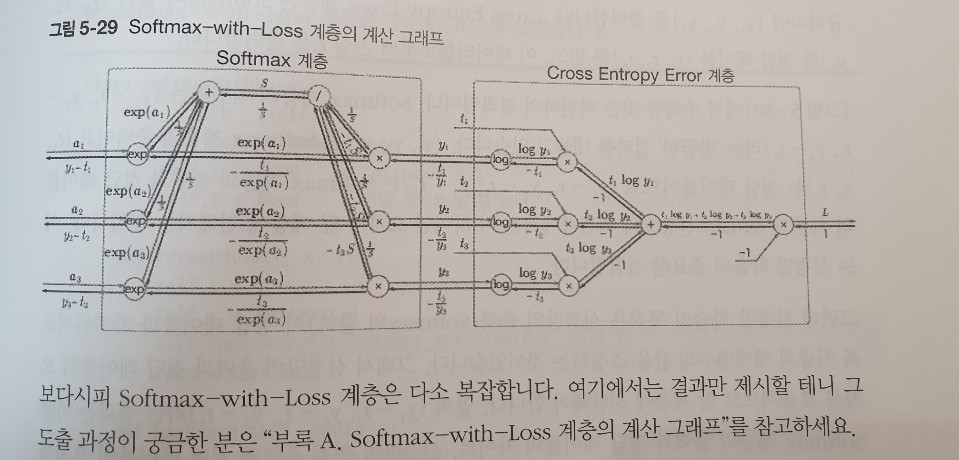

그리고 위의 계산을 아래와 같이 간소화 할 수 있다.
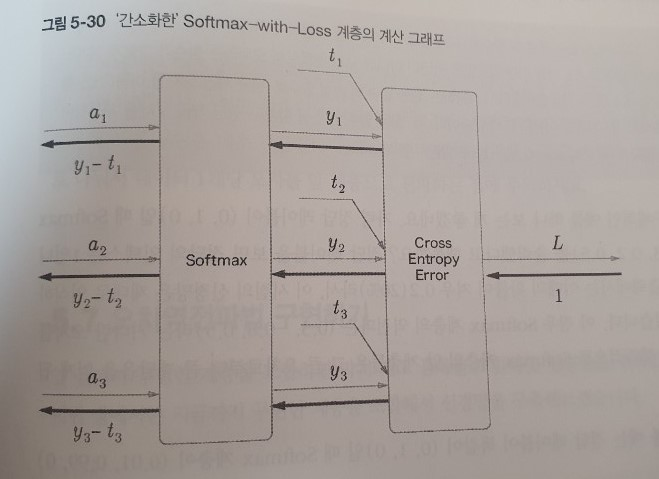

In [1]:
# Softmax-with-Loss 계층을 구현한 코드
class SoftmaxwithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax 출력
        self.x = None # 정답 레이블 (원-핫 벡터)
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(y)
        self.loss = cross_entry_errors(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx
    

# 오차역전파법 구현하기

위에서 구현한 계층을 조합하면 블록을 조합하듯 신경망을 구축할 수 있다. 지금껏 구현한 계층을 조합하여 신경망을 구축해보자

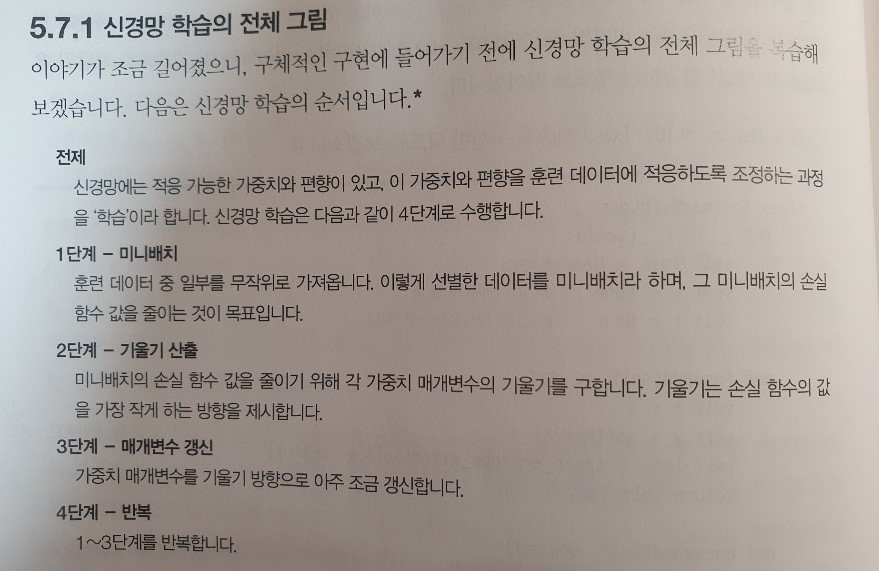

In [9]:
# 오차역전파법을 적용한 신경망 구현하기
# 2층 신경망을 TwoLayerNet 클래스로 구현

import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


- 위 구현 설명
위에서 신경망의 계층을 OrderedDict에 보관하는 점이 중요하다. OrderedDict은 순서가 있는 딕셔너리이다. 즉 순서가 있는 딕셔너리에 추가한 순서를 기억한다는 것이죠. 그래서 순전파 때는 추가한 순서대로 각 계층의 forward() 메서드를 호출하기만 하면 처리가 완료됨. 마찬가지로 역전파 때는 계층을 반대 순서로 호출하면 된다. 

- 오차역전파법으로 구한 기울기 검증
기울기 구하는 방법은 2 가지 인데 하나는 수치 미분을 써서 구하는 방법, 또 하나는 해석적으로 수식을 풀어 구하는 방법이다. 후자인 해석적 방법은 오차역전파법을 이용하여 매개변수가 많아도 효율적으로 계산할 수 있다. 따라서 느린 수치 미분 대신 오차역전파법을 사용한다.

수치 미분의 이점은 구현하기 쉽다는 것이지만 오차역전파법은 구현하기 복잡해서 종종 실수를 한다. 그래서 수치 미분의 결과와 오차역전파법의 결과를 비교하여 오차역전파법을 제대로 구현했는지 검증한다. 즉 이렇게 두 방식으로 구한 기울기가 일치하는 과정을 기울기 확인이라고 한다.

In [11]:
# 기울기 확인
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:4.367191172916239e-10
b1:2.6658577935326047e-09
W2:6.706642591136484e-09
b2:1.3988119770824703e-07


위의 결과는 수치 미분과 오차역전파법으로 구한 기울기의 차이가 매우작다고 알려준다. 가령 1번째 층의 편향 오차는 2.66* e-9다. 즉 오차역전파법으로 구한 기울기가 신뢰성이 있다는 것이다.

In [13]:
# 오차역전파법을 사용한 학습 구현하기
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.10963333333333333 0.1154
0.9022333333333333 0.9055
0.9227166666666666 0.9248
0.9364333333333333 0.9337
0.9447 0.9445
0.9515666666666667 0.9484
0.9576666666666667 0.9556
0.961 0.959
0.9635166666666667 0.9615
0.9665333333333334 0.9634
0.9697 0.9649
0.9717333333333333 0.9676
0.9728333333333333 0.9673
0.9747666666666667 0.9679
0.9761166666666666 0.9686
0.9774333333333334 0.9705
0.9771666666666666 0.9681


위의 코드는 기울기를 오차역전파법으로 구한다는 점뿐이다.

- 정리

이번장에서 계산 과정을 시각적으로 보여주는 방법인 계산 그래프를 배웠다. 계산그래프를 이용하여 신경망의 동작과 오차역전파법을 설명하고 그 과정을 계층이라는 단위로 구현했다. 예를 들어 ReLu, Softmax-with-Loss, Affine, Softmax 계층 등이다. 모든 계층에서 forward, backward로 메서드로 구현했고 순전파는 데이터를 순방향으로 전파하고 역전파는 역방향으로 전파함으로써 가중치 매개변수의 기울기를 효율적으로 구할 수 있다. 이처럼 동작을 계층으로 모듈화한 덕분에 신경망의 계층을 자유롭게 조합하여 원하는 신경망을 만들 수 있다.